In [8]:
import math
import ccxt
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib
from datetime import datetime
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from binance.client import Client
from scipy.stats import linregress
import pandas_ta as ta

In [9]:
client = Client('JLCON0ZJ9v4zX595o2W1rlvSIhIercTu2ugNLCMPZ88QAt8zvSe2vY3LDiiRjKMB','JMnozKSUlep8mBrXCW1b7mAdHDl5qcYv3GDfNOquyifCdbD4QmGXILR9A5V0FgKf')
start_str = 'Jan 1, 2021'
end_str = ''
coin = 'BTC'
klines = client.get_historical_klines(symbol=f'{coin}USDT', interval=client.KLINE_INTERVAL_4HOUR, start_str=start_str)  ##craw dữ liệu
df = pd.DataFrame(klines)
df = df.iloc[:,:6] ## Chỉ lấy 6 cột đầu.
df.columns = ['time','open','high','low','close','volume']
df = df.astype(float) ## Dữ liệu đang ở dạng string nên cần chuyển qua float.
df['time'] = [datetime.fromtimestamp(ts / 1000) for ts in df['time']] ##chuyển định dạng timestamp sang thời gian chuẩn YY/MM/DD 00:00 UTC

df.tail()

,time,open,high,low,close,volume
4233,2022-12-07 19:00:00,16793.29,16897.38,16765.12,16837.48,45582.55807
4234,2022-12-07 23:00:00,16837.48,16850.24,16778.21,16815.73,31381.52031
4235,2022-12-08 03:00:00,16815.13,16865.81,16793.70,16836.64,21635.69423
4236,2022-12-08 07:00:00,16836.64,16890.01,16780.01,16834.32,36098.63764
4237,2022-12-08 11:00:00,16834.32,16851.00,16777.00,16824.49,24247.90227


In [20]:
open = df['open']
high = df['high']
low  = df['low']
close = df['close']
volume = df['volume']
df.dropna()
avg = (df['high'] + df['low']) / 2
diff = (df['high'] - df['low'])
##Overlap Studies
df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
df['BBANDS_upperband'] = (df['BBANDS_upperband'] - avg) / close
df['BBANDS_middleband'] = (df['BBANDS_middleband'] - avg) / close
df['BBANDS_lowerband'] = (df['BBANDS_lowerband'] - avg) / close
df['DEMA'] = (talib.DEMA(close, timeperiod=30) - avg) / close
df['EMA'] = (talib.EMA(close, timeperiod=30) - avg) / close
df['HT_TRENDLINE'] = (talib.HT_TRENDLINE(close) - avg) / close
df['KAMA'] = (talib.KAMA(close, timeperiod=30) - avg) / close
df['MA'] = (talib.MA(close, timeperiod=30, matype=0) - avg) / close
df['MIDPOINT'] = (talib.MIDPOINT(close, timeperiod=14) - avg) / close
df['SMA'] = (talib.SMA(close, timeperiod=30) - avg) / close
df['T3'] = (talib.T3(close, timeperiod=5, vfactor=0) - avg) / close
df['TEMA'] = (talib.TEMA(close, timeperiod=30) - avg) / close
df['TRIMA'] = (talib.TRIMA(close, timeperiod=30) - avg) / close
df['WMA'] = (talib.WMA(close, timeperiod=30) - avg) / close
df['LINEARREG'] = (talib.LINEARREG(close, timeperiod=14) - close) / close
df['LINEARREG_INTERCEPT'] = (talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close) / close

df['AD'] = talib.AD(high, low, close, volume) / close
df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10) / close
df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0) / close
df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
df['HT_PHASOR_inphase'] /= close
df['HT_PHASOR_quadrature'] /= close
df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14) / close
df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD_macd'] /= close
df['MACD_macdsignal'] /= close
df['MACD_macdhist'] /= close
df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14) / close
df['MOM'] = talib.MOM(close, timeperiod=10) / close
df['OBV'] = talib.OBV(close, volume) / close
df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14) / close
df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1) / close
df['TRANGE'] = talib.TRANGE(high, low, close) / close

##Momentum Indicators
df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
df['BOP'] = talib.BOP(open, high, low, close)
df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
df['DX'] = talib.DX(high, low, close, timeperiod=14)

df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
df['RSI'] = talib.RSI(close, timeperiod=14)
df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
df['TRIX'] = talib.TRIX(close, timeperiod=30)
df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

df['ATR'] = talib.ATR(high, low, close, timeperiod=14)  # Chỉ báo về biên động thị trường
df['NATR'] = talib.NATR(high, low, close, timeperiod=14)

df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

df['BETA'] = talib.BETA(high, low, timeperiod=5)
df['CORREL'] = talib.CORREL(high, low, timeperiod=30)

df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
diff =pd.DataFrame.median(diff)
print(diff)
## Pattern Recognition

774.364999999998


In [22]:
#Phân nhóm dữ liệu
pipdiff = diff  # for TP
SLTPRatio = 2   # pipdiff/Ratio gives SL


def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length

    for line in range(0, length - barsupfront - 2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1, barsupfront + 2):
            value1 = open[line + 1] - low[line + i]
            value2 = open[line + 1] - high[line + i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ((valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff / SLTPRatio))):
                trendcat[line] = 1  # -1 downtrend
                break
            elif ((valueOpenLow <= (pipdiff / SLTPRatio)) and (-valueOpenHigh >= pipdiff)):
                trendcat[line] = 2  # uptrend
                break
            else:
                trendcat[line] = 0  # no clear trend

    return trendcat
df['mytarget'] = mytarget(16, df)




In [23]:
df.to_csv('target.csv',index =False)

In [24]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
    'MOM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',

    'ULTOSC',
    'WILLR',

    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])
df = df.dropna()
X = df[features]
y = df["mytarget"]


            ADX       ADXR       APO    AROONOSC  AROON_aroondown  \
88    19.925492  26.087262  0.053645   42.857143         7.142857   
89    20.418595  25.913244  0.044588   42.857143         0.000000   
90    20.227021  24.827783  0.039170   35.714286         0.000000   
91    20.236355  23.808834  0.034196  -50.000000        78.571429   
92    19.448762  22.548488  0.028925  -50.000000        71.428571   
...         ...        ...       ...         ...              ...   
4215  27.590720  30.884324 -0.000667   21.428571        14.285714   
4216  27.491103  30.619005 -0.000648   21.428571         7.142857   
4217  27.665437  30.506055 -0.001124  100.000000         0.000000   
4218  28.601400  31.026980 -0.000565   50.000000        50.000000   
4219  29.798561  31.864067  0.000787   57.142857        42.857143   

      AROON_aroonup  BBANDS_lowerband  BBANDS_middleband  BBANDS_upperband  \
88        50.000000         -0.033665           0.051146          0.135958   
89        42.85

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [32]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))


****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 49.0931%


In [33]:
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

C:\Users\DAD\AppData\Local\Temp\ipykernel_16264\552261614.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train, y_test = y[:train_index], y[train_index:]


****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 32.5272%


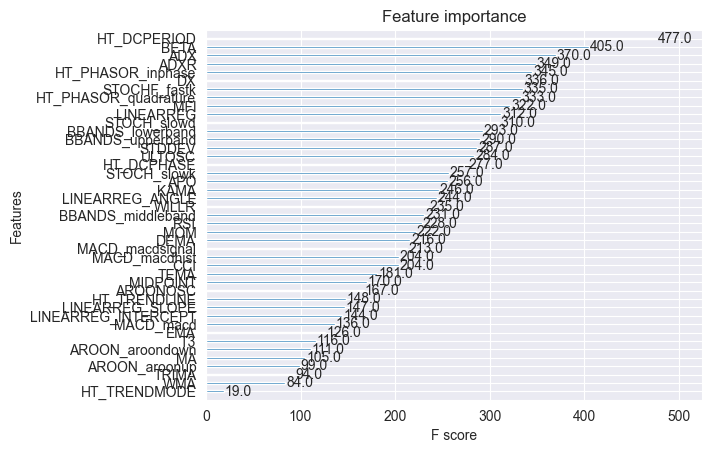

In [34]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()

In [ ]:
##BackTest : 
class TradingEnv:
    def __init__(self, balance_amount, balance_unit, trading_fee_multiplier, symbols):
        self.balance_amount = balance_amount
        self.balance_unit = balance_unit
        self.buys = []
        self.sells = []
        self.trading_fee_multiplier = trading_fee_multiplier
        self.symbols = symbols

        self.bottoms = {}
        self.reset_bottoms()

        self.tops = {}
        self.reset_tops()

    def buy(self, symbol, buy_price, time):
        self.balance_amount = (self.balance_amount / buy_price) * self.trading_fee_multiplier
        self.balance_unit = symbol
        self.buys.append([symbol, time, buy_price])

    def sell(self, sell_price, time):
        self.balance_amount = self.balance_amount * sell_price * self.trading_fee_multiplier
        self.sells.append( [self.balance_unit, time, sell_price] )
        self.balance_unit = 'USDT'

    def reset_bottoms(self):
        for symbol in self.symbols:
            self.bottoms[symbol] = 'none'

    def reset_tops(self):
        for symbol in self.symbols:
            self.tops[symbol] = 'none'

# VIP level 0, paying fees with BNB = 0.075%
env = TradingEnv(balance_amount=100,balance_unit='USDT', trading_fee_multiplier=0.99925, symbols=symbols)
for i in range(len(df)):
    if env.balance_unit == 'USDT':

        for symbol in symbols:
            if env.bottoms[symbol] == 'hit' and df[f'{symbol}-USD_Low'].iloc[i] > df[f'{symbol}_lower_band'].iloc[i]:
                env.bottoms[symbol] = 'released'
            if df[f'{symbol}-USD_Low'].iloc[i] < df[f'{symbol}_lower_band'].iloc[i]: #buy signal
                if env.bottoms[symbol] == 'released':
                    env.buy(symbol, df[f'{symbol}_lower_band'].iloc[i], df['OpenTime'].iloc[i])
                    env.reset_bottoms()
                    break
                else:
                    env.bottoms[symbol] = 'hit'

    if env.balance_unit != 'USDT':
        if env.tops[env.balance_unit] == 'hit' and (df[f'{env.balance_unit}-USD_High'].iloc[i] < df[f'{env.balance_unit}_upper_band'].iloc[i]):
            env.tops[env.balance_unit] = 'released'

        if df[f'{env.balance_unit}-USD_High'].iloc[i] > df[f'{env.balance_unit}_upper_band'].iloc[i]: #sell signal
            if env.tops[env.balance_unit] == 'released':
                env.sell(df[f'{env.balance_unit}_upper_band'].iloc[i], df['OpenTime'].iloc[i])
                env.reset_tops()
            else:
                env.tops[env.balance_unit] = 'hit'
